# Import

In [1]:
import numpy as np
import scipy
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm

import cirq
import pyscf
import openfermion
import openfermionpyscf 
import itertools

from pyscf import gto, scf, fci
from openfermion.transforms import jordan_wigner, get_fermion_operator
from openfermionpyscf import run_pyscf
from openfermion.utils import count_qubits
from openfermion.linalg import jw_hartree_fock_state
from openfermion.circuits import simulate_trotter, trotter
from openfermion import (
    MolecularData, get_sparse_operator, get_ground_state, FermionOperator,
    jw_get_ground_state_at_particle_number,
    expectation, uccsd_convert_amplitude_format,
    get_interaction_operator, QubitOperator, eigenspectrum,
    InteractionOperator
)

# Constant definition

In [2]:
CHEMICAL_ACCURACY = 1.5936e-3

# Define necessary Pauli operators (two-dimensional) as matrices
pauliX = np.array([[0,1],
                 [1,0]],
                dtype = complex)
pauliZ = np.array([[1,0],
                 [0,-1]],
                dtype = complex)
pauliY = np.array([[0,-1j],
                 [1j,0]],
                dtype = complex)

In [3]:
class Timer:
    def __init__(self):
        self.enable_debug = True
        self._last_point = time.time()
        self._point_stock = OrderedDict()

    def time_check(self, name: str = None):
        current_point = time.time()
        elapsed = current_point - self._last_point
        if name is not None and self.enable_debug:
            self._point_stock[name] = elapsed
            print(f"TimeCheck: {name} : {elapsed}s")
        self._last_point = current_point

    def reset(self):
        self._last_point = time.time()
        self._point_stock = OrderedDict()

timer = Timer()
timer.enable_debug = False
timer2 = Timer()
timer2.enable_debug = False

# VQE UCCSD method:

## Algorithm (JW transformation for example)

1. Preparation of the wavefunction by application of parameterized state preparation unitaries;
   1. Define the molecular in the OpenFermion, get necessary parameters such as number of qubits.
   2. Prepare the HF state by JW transformation
   3. Prepare the Unitary by JW transformation
   4. Prepare the Hamiltonian by the OpenFermion and do the JW transformation
2. Determination of the expectation value of every term in the Hamiltonian via an efficient partial tomography;
   1. Applied the Unitary on the HF state by trotterization
   2. Simulate the energy expectation
   3. Calculate the energy gradient by calculation or simulation
3. Calculation of the total energy and determination of a new set of state preparation parameters in a classical computer.
   1. Optimize the parameter in Unitary.

## Molecular definition

In [4]:
def relative_energy_error(ground_energy: dict):
    """
    Calculate the relative energy error compare to the exact result from openfermion FCI method.
    So the FCI result should be contained.

    Args:
        ground_energy (dict): (key, value) pairs are (method, energy) pairs

    """
    # Calculate the relative energy error
    methods = list(ground_energy.keys().__reversed__())  # Output the new added one in the front
    E0 = np.array(list(ground_energy.values().__reversed__()))
    try:
        E_fci = [ground_energy[key] for key in methods if 'FCI' in key][0]
    except KeyError:
        print("No FCI method specified")
    error = E0 - E_fci
    relative_error = error / E_fci
    relative_accuracy = error/CHEMICAL_ACCURACY * 100
    # format the output data
    number = len(E0)
    print("Calculated energy from different methods:")
    vol = 25
    print("|" + "="*vol*(number+1) + "|")
    methods_row = "|" + "method".center(vol)
    for name in methods:
        methods_row += "|"
        methods_row += name.center(vol-1)
    print(methods_row + "|")
    print("|" + "-"*vol*(number+1) + "|")
    energy_row = "|" + "Energy [Hatree]".center(vol)
    for energy in E0:
        energy_row += "|"
        energy_row += f"{energy.round(20)}".center(vol-1)
    print(energy_row + "|")
    print("|" + "-"*vol*(number+1) + "|")
    er_row = "|" + "relative_error".center(vol)
    for er_r in relative_error:
        er_row += "|"
        er_row += f"{er_r.round(10)}".center(vol-1)
    print(er_row + "|") 
    print("|" + "-"*vol*(number+1) + "|")
    era_row = "|" + "relative_accuracy [%]".center(vol)
    for era_r in relative_accuracy:
        era_row += "|"
        era_row += f"{era_r.round(10)}".center(vol-1)
    print(era_row + "|") 
    print("|" + "="*vol*(number+1) + "|")
    


In [5]:
# HeH+

def create_helonium(r: float = 0.914, show_energy: bool = False, user_energy: float = None) -> MolecularData:
    """
    Create a helonium molecule with given distance r.

    Args:
        r (float): distance of the atom in angstrom.
        show_energy (bool): if true, show energy of the atom with the calculation from openfermionscf
        user_energy (float): Energy calculated by user
    
    Returns:
        MolecularData (openfermion.MolecularData): data contain molecule information
    """

    geometry = [['He',[0,0,0]], ['H',[0,0,r]]]
    basis = 'sto-3g'  # Slater type orbital - approximated by 3 Gaussian orbital for each Slater determinant.
    multiplicity = 1 # spin multiplicity, 1 for spin singlet state of two electrons
    charge = +1 # indicate two electrons
    helonium = MolecularData(geometry, basis, multiplicity, charge)
    helonium_of = run_pyscf(helonium, run_fci = True, run_cisd=True, run_ccsd = True, run_mp2=True)
    if show_energy:
        HeH_ground_energy = OrderedDict()
        HeH_ground_energy['openfermion.FCI'] =helonium_of.fci_energy
        HeH_ground_energy['openfermion.CISD'] =helonium_of.cisd_energy
        HeH_ground_energy['openfermion.mp2_energy'] =helonium_of.mp2_energy
        HeH_ground_energy['openfermion.CCSD'] =helonium_of.ccsd_energy
        HeH_ground_energy['openfermion.hf_energy'] =helonium_of.hf_energy
        if user_energy:
            HeH_ground_energy['user_energy'] =user_energy
        relative_energy_error(HeH_ground_energy)
    return helonium
helonium = create_helonium(show_energy=True)

Calculated energy from different methods:
|======================================================================================================================================================|
|          method         | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8542821676730235   |  -2.8626947243046503   |  -2.8607985461595513   |  -2.8626947737981916   |  -2.8626947737981903   |
|------------------------------------------------------------------------------------------------------------------------------------------------------|
|      relative_error     |     -0.0029387017      |       -1.73e-08        |     -0.0006623925      |          0.0           |          -0.0          |
|---------------------------------------

## Get energy from Direct Matrix Calculation

### Prepare the ansatz and unitary

In [6]:
def get_JW_state_and_unitary(molecule: MolecularData) -> Tuple[List, int, int, np.ndarray, scipy.sparse.csc_matrix]:
    """
    Gets the state, unitary and Hamiltonian from the molecule data

    Args:
        molecule (openfermion.MolecularData): The molecule data contain the information

    Returns:
        packed_amplitudes (List): The packed amplitudes of the operators T
        n_qubits (int): The number of qubits
        n_electrons (int): The number of electrons
        HF_state (np.ndarray): The HF state as the ansatz
        hamiltonian_matrix (scipy.sparse.csc_matrix): The hamiltonian operator matrix
    """

    # Get information from molecule data
    n_qubits = molecule.n_qubits
    n_electrons = molecule.n_electrons
    n_orbitals = molecule.n_orbitals

    # Get the Hartree fock state
    HF_state = jw_hartree_fock_state(n_electrons, n_orbitals*2) 

    # Get the initial excitation operators amplitude from ccsd method
    ccsd_single_amps = molecule.ccsd_single_amps
    ccsd_double_amps = molecule.ccsd_double_amps
    packed_amplitudes = openfermion.uccsd_singlet_get_packed_amplitudes\
    (ccsd_single_amps, ccsd_double_amps, n_qubits, n_electrons)
    

    # Get the Hamiltonian
    hamiltonian = molecule.get_molecular_hamiltonian() 
    hamiltonian_operator = jordan_wigner(get_fermion_operator(hamiltonian))
    hamiltonian_matrix = get_sparse_operator(hamiltonian_operator)

    return packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian_matrix

### Get expectation from matrix operation

In [7]:
def get_expectation_from_matrix_operation(packed_amplitudes:List, n_qubits: int, n_electrons:int , HF_state: np.ndarray, hamiltonian_matrix:scipy.sparse.csc_matrix, repetitions: int = 100) -> float:
    """
    Get the expected value of the energy from : <HF|U+ H U|HF>

    Args:
        packed_amplitudes (List): The packed amplitudes of the operators T
        n_qubits (int): The number of qubits
        n_electrons (int): The number of electrons
        F_state (np.ndarray): The HF state as the ansatz
        hamiltonian_matrix (scipy.sparse.csc_matrix): The hamiltonian operator matrix
        repetitions: redundant, no use here
        
    Returns:
        energy: The expected value of the energy
    """

    T_operator = openfermion.uccsd_singlet_generator(packed_amplitudes, n_qubits, n_electrons)
    T_sparse_matrix = get_sparse_operator(T_operator)
    uccsd_matrix = scipy.sparse.linalg.expm(T_sparse_matrix)
    uccsdState = scipy.sparse.csc_matrix.dot(uccsd_matrix, HF_state)
    ket = scipy.sparse.csc_matrix(uccsdState, dtype=complex).transpose()
    # if not isinstance(uccsdState,scipy.sparse.csc_matrix):
    #   ket = scipy.sparse.csc_matrix(uccsdState, dtype=complex).transpose()
    # else:
    #   ket = uccsdState
      
    bra = ket.transpose().conj()

    energy = (bra * hamiltonian_matrix * ket)[0,0].real
    return energy

In [8]:
packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian_matrix = get_JW_state_and_unitary(helonium)
energy = get_expectation_from_matrix_operation(packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian_matrix)
print(f"get the initial trial state energy: {energy}")

get the initial trial state energy: -2.8626942337879715


## Get energy from Cirq simulation

### Prepare the group Hamiltonian

In [9]:
def get_JW_state_and_unitary_cirq(molecule: MolecularData) -> Tuple[List, int, int, np.ndarray, openfermion.QubitOperator]:
    """
    Gets the state, unitary and Hamiltonian from the molecule data

    Args:
        molecule (openfermion.MolecularData): The molecule data contain the information

    Returns:
        packed_amplitudes (List): The packed amplitudes of the operators T
        n_qubits (int): The number of qubits
        n_electrons (int): The number of electrons
        HF_state (np.ndarray): The HF state as the ansatz
        hamiltonian_operator (openfermion.QubitOperator): The hamiltonian operator in the Pauli bases
    """

    # Get information from molecule data
    n_qubits = molecule.n_qubits
    n_electrons = molecule.n_electrons
    n_orbitals = molecule.n_orbitals

    # Get the Hartree fock state
    HF_state = jw_hartree_fock_state(n_electrons, n_orbitals*2) 

    # Get the initial excitation operators amplitude from ccsd method
    ccsd_single_amps = molecule.ccsd_single_amps
    ccsd_double_amps = molecule.ccsd_double_amps
    packed_amplitudes = openfermion.uccsd_singlet_get_packed_amplitudes\
    (ccsd_single_amps, ccsd_double_amps, n_qubits, n_electrons)
    

    # Get the Hamiltonian
    hamiltonian = molecule.get_molecular_hamiltonian() 
    hamiltonian_operator = jordan_wigner(get_fermion_operator(hamiltonian))
    return packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian_operator

In [10]:
def Ket_to_Vector(hf_ket):
    """
    Convert a Ket of HF state to a vector representation.

    Args:
        ket (list): the list representation of a Ket of a HF state. |0> = [1, 0].T, |1> = [0, 1].T.
    
    Returns:
        hf_vector (list): the vector representation of a HF state
    """

    hf_vector = [1]
    for ket in hf_ket:
        v = [1-ket, ket]
        hf_vector = np.kron(hf_vector, v)
    return hf_vector

def Vector_to_Ket(hf_vector):
    """
    Convert a vector to a list representation of a Ket.

    Args:
        hf_vector (list): the vector representation of a HF state

    Returns:
        hf_ket (list): the list representation of a Ket of a HF state
    """

    dim = len(hf_vector)
    hf_ket = []

    while dim>1:
        if any (hf_vector[i] for i in range(int(dim/2))):
            # Ket is of the form |0>|...>.  |0> = [1, 0].T
            hf_ket.append(0)
            # Get the vector representing the state of the remaining qubits.
            hf_vector = hf_vector[:int(dim/2)]
        else:
            # Ket is of the form |1>|...>. |1> = [0, 1].T
            hf_ket.append(1)
            # Get the vector representing the state of the remaining qubits.
            hf_vector = hf_vector[int(dim//2):]
        dim = dim/2
    return hf_ket    


In [11]:
def convert_hamiltonian(hamiltonian_operator: openfermion.QubitOperator, n_qubits: int):
  '''
  Convert the hamiltonian from openfermion.QubitOperator to a dict, so that some Pauli string could be measured with one shot

  Arguments:
    hamiltonian_operator (openfermion.QubitOperator): the Hamiltonian in the Pauli basis.
    n_qubits (int): number of qubits
  Returns:
    hamiltonian_dict (dict): the Hamiltonian as a dictionary with Pauli strings (eg 'YXZI') as keys and their coefficients as values.
  '''

  hamiltonian_dict = OrderedDict()
  # Iterate through the terms in the Hamiltonian
  for term in hamiltonian_operator.get_operators():
    coefficient = list(term.terms.values())[0]
    operators = ["I"] * n_qubits
    for (qubit, Pauli_string) in list(term.terms.keys())[0]:
        operators[int(qubit)] = Pauli_string
    hamiltonian_dict["".join(operators)] = coefficient

  return hamiltonian_dict

In [12]:
hm = openfermion.QubitOperator('X0 Y3', 0.5)+ 0.6 * QubitOperator('X1 Y3') - 0.6 * QubitOperator('X2 Z3')
convert_hamiltonian(hm, 4)
type(hm)

openfermion.ops.operators.qubit_operator.QubitOperator

In [13]:
def find_sub_strings(main_string: str, hamiltonian_dict: dict, checked: List[str]) -> Tuple[dict, List[str]]:
    """
    Find the string that in the H_df that only differ from the main string with Identity operator. These grouped operators could be measured in the same single shot.

    Args:
        main_string (str): The main string contained the largest number of to-be-measured operators. 
                            Such as "XZ" in ["XZ", "IZ", "XI", "II"]. So that after measuring "X" and "Z" on qubit 1 and 2, respectively,
                            We can get the measured result of "IZ", "XI" and "II" from the same single shot measurement. Note "I" always gives 1 of the expectation measured.
                            If we choose the "IZ" operator to be the main string, then according to the function, only "I" and "Z" on qubit 1 and 2 will be measured.
                            Hence, the "X" result of qubit 1 can not get the result from the main string measurement.
        hamiltonian_dict (dict): Contain the Hamiltonian information to prepare the Hamiltonian
        checked (List[str]): A list of Pauli string that is already grouped
    
    Returns:
        grouped_operators: The grouped operators list which is a dict:
                                {
                                    substring (str, like "01" if pauli string is "IZ", which differ from the main_string with only identity): coefficients in the Hamiltonian
                                }
    """
    
    grouped_operators = OrderedDict()
    
    # Go through the keys in the dictionary representing the Hamiltonian that 
    # haven't been grouped yet, and find those that only differ from mainString by identities
    for Pauli_string in hamiltonian_dict:
        if Pauli_string == "R" or Pauli_string in checked: # ignore the "distance term"
            continue
            
        if(all((op1==op2 or op2=="I") for op1, op2 in zip(main_string, Pauli_string))):
            # The string only differs from mainString by identities
            
            # Represent the string as a substring of the main one
            boolean_string="".join([str(int(op1==op2)) for op1,op2 in zip(main_string, Pauli_string)])
                
            # Add the boolean string representing this string as a key to 
            # the dictionary of grouped operators, and associate its 
            # coefficient as its value
            grouped_operators[boolean_string] = hamiltonian_dict[Pauli_string]
            
            # Mark the string as grouped, so that it's not added to any 
            #other group
            checked.append(Pauli_string)
                
    return (grouped_operators, checked)

In [14]:
def group_Hamiltonian(hamiltonian_dict: dict) -> dict:
    """
    Group the Hamiltonian so that the some Pauli string could be measured in one shot.

    Args:
        hamiltonian_dict (hamiltonian_dict): Contain the Hamiltonian information to prepare the Hamiltonian
    
    Returns:
        grouped_Hamiltonian: The grouped Hamiltonian which is a dict:
                                {
                                    main_string (str, like "XZ"):
                                    {
                                        subs_tring (str, like "01" if Pauli string is "IZ", which differ from the main_string with only identity): coefficients in the Hamiltonian
                                    }
                                }
    """

    grouped_Hamiltonian=OrderedDict()
    checked=[]
    
    # Go through the hamiltonian, starting by the terms that have less identity operators
    for main_string in sorted(hamiltonian_dict, key = lambda Pauli_string: Pauli_string.count("I")):
        if main_string in checked: # ignore the "distance term"
            continue
        # Call find_sub_strings to find all the strings in the dictionary that 
        # only differ from mainString by identities, and organize them as a 
        # dictionary (groupedOperators)
        grouped_operators, checked = find_sub_strings(main_string, hamiltonian_dict, checked)
        
        # Use the dictionary as a value for the mainString key in the 
        #groupedHamiltonian dictionary
        grouped_Hamiltonian[main_string] = grouped_operators
    return grouped_Hamiltonian

### Trotterization

1. Prove the Equation used for trotter decomposition
    $$
    e^{iZ_1\otimes...\otimes Z_n \theta} = C_1X_2 \otimes ... \otimes C_{n-1}X_n \cdot e^{iZ_n \theta} \cdot C_{n-1}X_n \otimes ... \otimes C_1X_2
    $$
    where $C_{n-1}X_n$ is the Cnot gate with control and target qubit are $n-1$ and $n$ qubit, respectively.
    $$
    \begin{aligned}
    e^{iZ_1\otimes...\otimes Z_n \theta} =& \left[\begin{array}{cc}
    e^{i Z_2 \otimes...\otimes Z_n \theta} & 0 \\
    0 & e^{-i Z_2 \otimes...\otimes Z_n \theta}
    \end{array}\right]\\
    =& \left[\begin{array}{cc}
    e^{i Z_2 \otimes...\otimes Z_n \theta} & 0 \\
    0 & X_2e^{i Z_2 \otimes...\otimes Z_n \theta}X_2
    \end{array}\right]\\
    =& \left[\begin{array}{cc}
    I & 0 \\
    0 & X_2
    \end{array}\right]\cdot \left[\begin{array}{cc}
    e^{i Z_2 \otimes...\otimes Z_n \theta} & 0 \\
    0 & e^{i Z_2 \otimes...\otimes Z_n \theta}
    \end{array}\right]  \cdot \left[\begin{array}{cc}
    I & 0 \\
    0 & X_2
    \end{array}\right]\\
    =&C_1X_2e^{i Z_2 \otimes...\otimes Z_n \theta}C_1X_2\\
    =&C_1X_2 \otimes ... \otimes C_{n-1}X_n \cdot e^{iZ_n \theta} \cdot C_{n-1}X_n \otimes ... \otimes C_1X_2
    \end{aligned}
    $$
    Below, we also use the numerical calculations to prove.
2. Decomposition of the trotter operator.
    1. The trotter operator: $e^{i\theta  P}$, where $P$ is a multi product of a series of Pauli matrix, such as $\sigma_x^1\cdot\sigma_z^2\cdot\sigma_x^4$
    2. First we transit the P to the Z series.
        $$
        R_y(\frac{\pi}{2})ZR_y(-\frac{\pi}{2}) = X,\ \ \ \  R_x(-\frac{\pi}{2}) Z R_x(\frac{\pi}{2}) = Y
        $$
        So we can write
        $$
        e^{i\theta X} = R_y(\frac{\pi}{2}) e^{i\theta Z} R_y(-\frac{\pi}{2}),   \ \ \ \ e^{i\theta Y} =  R_x(-\frac{\pi}{2}) e^{i\theta Z} R_x(\frac{\pi}{2}) 
        $$
        for each qubit. Then the trotter operators are consist of single qubit gates of $\{R_x(\frac{\pi}{2}), R_y(\frac{\pi}{2})\}$ and an exponential of $Z$ Pauli series operators $e^{iZ_1\otimes...\otimes Z_n \theta}$.
    3. Using the CNOT gate and single qubit rotate to simulate $e^{iZ_1\otimes...\otimes Z_n \theta}$:
        $$
        e^{iZ_1\otimes...\otimes Z_n \theta} = C_1X_2 \otimes ... \otimes C_{n-1}X_n \cdot e^{iZ_n \theta} \cdot C_{n-1}X_n \otimes ... \otimes C_1X_2
        $$


In [15]:
# Prove of exp(i Z^n x) == CX^n exp(ix) CX^n


pauliZ = np.array([[1,0],
                 [0,-1]],
                dtype = complex)
pauliI = np.array([[1,0],
                 [0,1]],
                dtype = complex)

Cnot = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]],
                dtype = complex)

def cal_exp_Zn(n: int, x: float) -> float:
    """
    Calculate the exp(i Z^n x) == CX^n exp(ix) CX^n

    Args:
        n (int): The number of the qubits
        x (float): The phase
    
    Returns:
        norm (float): The norm of the difference between the two matrix
    """

    Zn = 1.0
    for i in range(n):
        Zn = np.kron(pauliZ, Zn)
    exp_Zn = scipy.linalg.expm(1j*Zn*x)

    CXn = 1.0
    for i in range(n-1):
        CXn = np.dot(np.kron(np.eye(2**i), np.kron(Cnot, np.eye(2**(n-i-2) ))), CXn)
    CXn = np.dot(np.kron(np.eye(2**(n-1)), scipy.linalg.expm(1j*pauliZ*x)), CXn)
    for i in range(n-2, -1, -1):
        CXn = np.dot(np.kron(np.eye(2**i), np.kron(Cnot, np.eye(2**(n-i-2) ))), CXn)
    diff = exp_Zn - CXn
    # print(f"norm = {np.linalg.norm(diff)} ")
    return np.linalg.norm(diff)

eq_list = []
for i in range(100):
    order = np.random.randint(2, 10)
    eq_list.append(cal_exp_Zn(order, np.random.random()))
print(f"They are all equal to 0? Anser = {not any(eq_list)}")

They are all equal to 0? Anser = True


In [16]:
def trotter_step(operator: openfermion.QubitOperator, qubits: cirq.LineQubit , time: float) -> cirq.Gate: 
  '''
  Creates the circuit for applying e^(-j*operator*time), simulating the time
  evolution of a state under the Hamiltonian 'operator'.

  Args:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator, openfermion.InteractionOperator]): the operator to be simulated
    qubits ([cirq.LineQubit]): the qubits that the gates should be applied to
    time (float): the evolution time

  Returns:
    trotterGates ( -> cirq.Gate): the list of CIRQ gates that apply the trotterized operator
  '''

  # If operator is an InteractionOperator, shape it into a FermionOperator
  if isinstance(operator, InteractionOperator):
    operator = get_fermion_operator(operator)

  # If operator is a FermionOperator, use the Jordan Wigner transformation
  #to map it into a QubitOperator
  if isinstance(operator, FermionOperator):
    operator = jordan_wigner(operator)

  # Initialize list of gates
  trotter_gates = []

  # Order the terms the same way as done by OpenFermion's 
  # trotter_operator_grouping function (sorted keys) for consistency.
  ordered_terms = sorted(list(operator.terms.keys()))

  # Add to trotterGates the gates necessary to simulate each Pauli string,
  # going through them by the defined order
  for pauli_string in ordered_terms:

    # Get real part of the coefficient (the immaginary one can't be simulated,
    # as the exponent would be real and the operation would not be unitary).
    # Multiply by time to get the full multiplier of the Pauli string.
    coef = float(np.real(operator.terms[pauli_string]))*time

    # Keep track of the qubit indices involved in this particular Pauli string.
    # It's necessary so as to know which are included in the sequence of CNOTs 
    # that compute the parity
    involved_qubits = []

    # Perform necessary basis rotations
    for pauli in pauli_string:

      # Get the index of the qubit this Pauli operator acts on
      qubit_index = pauli[0]
      involved_qubits.append(qubit_index)

      # Get the Pauli operator identifier (X,Y or Z)
      pauli_op = pauli[1]

      if pauli_op == "X":
        # Rotate to X basis
        trotter_gates.append(cirq.ry(-np.pi/2).on(qubits[qubit_index]))

      if pauli_op == "Y":
        # Rotate to Y Basis
        trotter_gates.append(cirq.rx(np.pi/2).on(qubits[qubit_index]))

    # Compute parity and store the result on the last involved qubit
    for i in range(len(involved_qubits)-1):

      control = involved_qubits[i]
      target = involved_qubits[i+1]

      trotter_gates.append(cirq.CX(qubits[control], qubits[target]))
    
    # Apply e^(-i*Z*coef) = Rz(coef*2) to the last involved qubit
    last_qubit = max(involved_qubits)
    trotter_gates.append(cirq.rz(coef*2).on(qubits[last_qubit]))

    # Uncompute parity
    for i in range(len(involved_qubits)-2,-1,-1):

      control = involved_qubits[i]
      target = involved_qubits[i+1]

      trotter_gates.append(cirq.CX(qubits[control],qubits[target]))

    # Undo basis rotations
    for pauli in pauli_string:

      # Get the index of the qubit this Pauli operator acts on
      qubit_index = pauli[0]

      # Get the Pauli operator identifier (X,Y or Z)
      pauli_op = pauli[1]

      if pauli_op == "X":
        # Rotate to Z basis from X basis
        trotter_gates.append(cirq.ry(np.pi/2).on(qubits[qubit_index]))

      if pauli_op == "Y":
        # Rotate to Z basis from Y Basis
        trotter_gates.append(cirq.rx(-np.pi/2).on(qubits[qubit_index]))

  return trotter_gates

def trotterize_operator(operator: openfermion.QubitOperator, qubits: cirq.LineQubit , time: float, steps: int) -> cirq.Gate:
  '''
  Creates the circuit for applying e^(-j*operator*time), simulating the time
  evolution of a state under the Hamiltonian 'operator', with the given 
  number of steps. 
  Increasing the number of steps increases precision (unless the terms in the 
  operator commute, in which case steps = 1 is already exact).
  For the same precision, a greater time requires a greater step number
  (again, unless the terms commute)

  Args:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator, openfermion.InteractionOperator]): the operator to be simulated
    qubits ([cirq.LineQubit]): the qubits that the gates should be applied to
    time (float): the evolution time
    steps (int): the number of trotter steps to split the time evolution into

  Returns:
    trotterGates (cirq.OP_TREE): the list of CIRQ gates that apply the trotterized operator
  '''
  
  trotter_gates = []
  
  # Divide time into steps and apply the evolution operator the necessary 
  #number of times
  for step in range(1,steps+1):
    trotter_gates += (trotter_step(operator, qubits, time/steps))
  return trotter_gates

### Estimating the required shot count

See [arxiv:1507.08969](https://https://arxiv.org/pdf/1507.08969.pdf). We write the Hamiltonian as a sum of Pauli strings, as usual:
$$H = \sum_{i=1}^{N_{terms}}h_iO_i$$
The error coming from the finite number of shots in the expectation estimation can be written
$$\epsilon^2 = \sum_i\frac{|h_i|^2Var(O_i)}{M_i}$$

The variances depend, not only on the Pauli operators appearing in the Hamiltonian, but also on the particular state. We can bound them as $Var(O_i)\leq1$, since any Pauli operator has $\pm1$ eigenvalues and so will their product.

Without further knowledge about their variance, the best choice is to distribute the shots by the operators proportionatelly to the norm of their coefficients: $M_i\propto|h_i|$. Assuming this optimal distribution, one can estimate the necessary number of shots to hit a precision $\epsilon$ as
$$M\approx\frac{(\sum_i|h_i|)^2}{\epsilon^2}$$
The term $(\sum_i|h_i|)^2$ will depend strongly on the molecule in study, and make it so that bigger molecules require a larger number of shots for the same precision.

Given that chemical accuracy is $1$ kcal/mol $\approx 1.59\times10^{-3}$ Hartree, achieving it requires
$$M\approx0.4\times10^6\times(\sum_i|h_i|)^2$$
This is already of the order of $10^7$ to $10^8$ for small molecules like helonium and lithium hydride; $Fe_2S_2$, for instance, would require $10^{13}$ shots.

This number of shots needs to be performed every time one needs to evaluate the energy, which happens many times throughout the optimization - especially for larger molecules, in which there are many parameters to optimize. And it still doesn't guarantee proper functionning of the optimizer: it guarantees chemical accuracy in the energy estimates, but the final estimate isn't necessarily close to the ground state. The error might still be big enough to confuse the optimizer into picking a wrong guess.

In [17]:
def get_required_shots(qubit_hamiltonian: openfermion.QuadOperator) -> int:
    """
    Get the required shots to reach the chemical accuracy

    Args:
      qubit_hamiltonian (openfermion.QuadOperator): qubit hamiltonian
    
    Returns:
      shots (int): required shots
    """
    total = 0

    for term in qubit_hamiltonian.get_operators():
        coefficient = list(term.terms.values())[0]
        total += np.abs(coefficient)
    shots = total**2 / (CHEMICAL_ACCURACY) ** 2
    return int(shots)

### Get expectation from state measurement.
1. Get expectation values of Pauli matrix, such as X, Z used here, from a given state $|\phi\rangle = \alpha |0\rangle + \beta |1\rangle$. (The Cirq measure the $|\langle 1|\phi\rangle|^2$ ). To simulate the real quantum computer, we here only use the measurement of the qubit to give the expectation values.
   1. For Z:
      $$
      \begin{aligned}
      \langle \phi|Z| \phi\rangle &= \alpha^*\alpha - \beta^*\beta\\
      &= 1- 2\beta^*\beta\\
      & = 1 - 2|\langle 1| \phi\rangle|^2
      \end{aligned}
      $$
   2. For X:
      $$
      \begin{aligned}
      \langle \phi|X| \phi\rangle &= \alpha^*\beta + \beta^*\alpha\\
      &= 1- (\alpha^*\alpha + \beta^*\beta - \alpha^*\beta - \beta^*\alpha)\\
      & = 1 - 2\frac{(\alpha - \beta)}{\sqrt{2}}\frac{(\alpha^* - \beta^*)}{\sqrt{2}}\\
      & = 1 - 2|\langle 1|H| \phi\rangle|^2
      \end{aligned}
      $$
   3. For Y:
      $$
      \begin{aligned}
      \langle \phi|Y| \phi\rangle &= -i(\alpha^*\beta - \beta^*\alpha)\\
      &= 1- (\alpha^*\alpha + \beta^*\beta + i\alpha^*\beta - i\beta^*\alpha)\\
      & = 1 - 2\frac{(\alpha + i\beta)}{\sqrt{2}}\frac{(\alpha^* - i\beta^*)}{\sqrt{2}}\\
      & = 1 - 2|\langle 1|\text{Rx}(-\frac{\pi}{2})| \phi\rangle|^2
      \end{aligned}
      $$
      where $\text{Rx}(-\frac{\pi}{2}) = \exp{(i\frac{\pi}{2}\sigma_X)}$
   4. For I: return 1
2. ***Notice***: The measurement here is single shot. For the tangled state, the measurement result should be $E(M_{q1}\cdot M_{q2})$, not $E(M_{q1})\cdot E(M_{q2})$. Because the tangled state measurement of qubit 1 will collapse the qubit 2.

In [18]:
def measure_expectation_from_Cirq(packed_amplitudes: List[float], n_qubits: int, n_electrons: int,  HF_state: List[float], main_string: str, sub_Hamiltonian: dict, repetitions: int = 1000) -> float:
    """
    Calculate the expectation for a given state initial parameters and operator.

    Args:
        packed_amplitudes (List): The packed amplitudes of the operators T
        n_qubits (int): The number of qubits
        n_electrons (int): The number of electrons
        HF_state (np.ndarray): The HF state as the ansatz in the qubit basis, such as |1100>
        main_string (str): Operator, such as "XZ" for two qubit respectively, used to calculate the expectation.
        sub_Hamiltonian (dict): The sub Hamiltonian which contrain the Pauli operators that can be measured in one single shot
        repetitions (int): The number of times to repeat the simulation.

    Returns:
        energy (float): Expectation energy.

    """

    if main_string == "I"*n_qubits:
        # print(sub_Hamiltonian)
        return 1.0*sub_Hamiltonian["1"*n_qubits]
    # Initialize qubits and circuit.
    timer.reset()

    qubits=cirq.LineQubit.range(n_qubits)
    circuit=cirq.Circuit()
    HF_gates = [cirq.X(qubits[i]) for i in range(n_electrons)]
    # Add gates to the circuit that prepare the state corresponding to the initial parameters.
    T_operator = openfermion.uccsd_singlet_generator(packed_amplitudes, n_qubits, n_electrons)
    if isinstance(T_operator, FermionOperator):
        T_operator = jordan_wigner(T_operator)
    trotter_gates = trotterize_operator(1j*T_operator, qubits, time=1, steps=1)

    # trotter_gates = simulate_trotter(
    #     qubits, T_operator, time,
    #     n_steps=1,
    #     order=0,
    #     algorithm=trotter.LINEAR_SWAP_NETWORK)

    state_preparation_gates = HF_gates
    state_preparation_gates.append(trotter_gates)
    circuit.append(state_preparation_gates)
    cirq.eject_z(circuit)
    cirq.drop_negligible_operations(circuit)
    ## Get prepared state of the circuit, verify the expectation energy.

    # final_state = cirq.final_state_vector(circuit)
    # print(f"final_state = {final_state}")
    # bra = np.array(final_state)
    # ket = np.array(bra).conj().T
    # H_matrix = operator_list[operators]
    # ave =  np.real(np.dot(np.dot(bra, H_matrix),ket))
    # print(f"ave = {ave}, norm = {np.dot(bra, ket)}")

    # Add measurements to the circuit corresponding to the operator string
    N_measurement = 0
    for i in range(n_qubits):
        op = main_string[i]
        assert op in ["I", "X", "Y", "Z"], f"operator {op} is not a valid Pauli matrix"
        if op == "X":
            rx90 = cirq.ry(np.pi/2)
            circuit.append(rx90(qubits[i]))
        elif op == "Y":
            rx90 = cirq.rx(-np.pi/2)
            circuit.append(rx90(qubits[i]))
        
        if op != "I": 
            circuit.append(cirq.measure(qubits[i], key=str(i)))
            N_measurement += 1
    timer.time_check(name="create circuits")
    
    # Sample the desired number of repetitions
    if (main_string!="I"*n_qubits):
        s=cirq.Simulator()
        results=s.run(circuit, repetitions=repetitions)
    timer.time_check(name="run the circuit")

    # For each substring, initialize a dict contain all the shot result of repetitions
    total={}
    for sub_string in sub_Hamiltonian:
        total[sub_string]= []
    # Calculate the expectation value of each Pauli string by averaging over  
    # all the repetitions
    data_length = len(results.data)
    dt = np.zeros(shape=(n_qubits, data_length))
    for i, x_index in enumerate(results.data.columns):
        dt[int(x_index)] = results.data[x_index]
    for sub_string in sub_Hamiltonian:
        meas = np.ones(shape = (data_length, ))
        for i in range(n_qubits):
            if (sub_string[i]!="0"):
                meas = meas*(1-2*dt[i])
        total[sub_string] = meas

    timer.time_check(name="gather results")
    expectation_energy = 0
    data_mean = results.data.mean()
    # Calculate the expectation value of the subHamiltonian, by multiplying
    # the expectation value of each substring by the respective coefficient
    for sub_string in sub_Hamiltonian:
        # Get the expectation value of this substring by taking the average
        # ave = data_mean[main_string + sub_string]
        ave = np.array(total[sub_string]).mean()
        # Add this value to the total expectation value, weighed by its coefficient
        expectation_energy += ave*sub_Hamiltonian[sub_string]
        # print(main_string+sub_string, ave, sub_Hamiltonian[sub_string] )
    timer.time_check(name="calculate expectation energy")
    
    return expectation_energy

In [19]:
def get_expectation_from_Cirq(packed_amplitudes:List, n_qubits: int, n_electrons:int , HF_state: np.ndarray, hamiltonian_operator: openfermion.QubitOperator, repetitions: int = 100) -> float:
    """
    Get the expected value of the energy from : <HF|U+ H U|HF>

    Args:
        packed_amplitudes (List): The packed amplitudes of the operators T
        n_qubits (int): The number of qubits
        n_electrons (int): The number of electrons
        HF_state (np.ndarray): The HF state as the ansatz
        hamiltonian_operator (openfermion.QubitOperator): The hamiltonian operator in Pauli bases
        repetitions: redundant, no use here
        
    Returns:
        energy: The expected value of the energy
    """

    ket = Vector_to_Ket(HF_state)
    energy = 0
    grouped_Hamiltonian = group_Hamiltonian(convert_hamiltonian(hamiltonian_operator, n_qubits))
    for main_string in grouped_Hamiltonian:
        energy += measure_expectation_from_Cirq(packed_amplitudes, n_qubits, n_electrons, ket, main_string, grouped_Hamiltonian[main_string], repetitions)
    return np.real(energy)

# VQE method

In [20]:
def VQE(packed_amplitudes:List, n_qubits: int, n_electrons:int , HF_state: np.ndarray, hamiltonian_matrix:scipy.sparse.csc_matrix, 
        maxiter: int = 1000, gtol: float = 1e-4, 
        get_expectation_func: callable = get_expectation_from_matrix_operation, repeations: int = 1000) -> float:
    """
    Optimized the parameters to given the lowest energy expectation

    Args:
        packed_amplitudes (List): The packed amplitudes of the operators T
        n_qubits (int): The number of qubits
        n_electrons (int): The number of electrons
        F_state (np.ndarray): The HF state as the ansatz
        hamiltonian_matrix (scipy.sparse.csc_matrix): The hamiltonian operator matrix
        maxiter: The maximum number of times to run the optimization
        gtol: Gradient norm must be less than gtol before successful termination
        get_expectation_func: Callable that returns the expected value given the (parameters, H_df) as arguments
        repetitions (int): The number of times to repeat the simulation.

    Returns:
        energy: The expected value of the energy from : <bra|H|ket>
    """

    options={
        "maxiter": maxiter, # Maximum iteration of optimization
        "gtol": gtol, # Acceptable absolute error in xopt for convergence
        }

    # dim=len(parameters)
    # initialSimplex=np.array([parameters,]*(dim+1))
    
    # for i in range(dim):
    #     initialSimplex[i+1][i]+=0.7
    
    # # Select the options for the optimization
    # options={
    #     #"disp": True,
    #     "maxfev": maxiter, # Maximum function evaluations
    #     "xatol": 0.13, # Acceptable absolute error in xopt for convergence
    #     "adaptive": True,
    #     "initial_simplex": initialSimplex
    #     }
        
    # optResults=scipy.optimize.minimize(get_expectation_func, parameters, (H_df, repeations),\
    #                             method='Nelder-Mead', options=options)
    # optResults=scipy.optimize.minimize(get_expectation_func,\
    #                             packed_amplitudes,\
    #                             (n_qubits, n_electrons, HF_state, hamiltonian_matrix, repeations),\
    #                             method='BFGS', options=options)
    optResults=scipy.optimize.minimize(get_expectation_func,\
                                packed_amplitudes,\
                                (n_qubits, n_electrons, HF_state, hamiltonian_matrix, repeations),\
                                method='COBYLA')

    return optResults

In [21]:
def get_dissociation_curve(helonium_r: np.ndarray, maxiter: int = 10000, gtol: float = 1e-4, get_expectation_func: callable = get_expectation_from_matrix_operation, simulation:bool = False, repetitions: int = 100, optimization: bool=True) -> Tuple[np.ndarray]:
    """
    Using VQE to calculate dissociation curves according to the Hamiltonian.

    Args:
        helonium_r (np.ndarray): Distance between the HeH+ two atoms with unit in angstrom.
        maxiter: The maximum number of times to run the optimization
        gtol: Gradient norm must be less than gtol before successful termination
        get_expectation_func: Callable that returns the expected value given the (parameters, H_df) as arguments
        simulation (bool): Whether use Cirq to simulate
        repetitions (int): The number of times to repeat the simulation.
        optimization (bool): Whether use VQE to optimize the parameters
    
    return (list): the information array
    """

    groundEnergy_list = []  # record the ground energy
    packed_amplitudes_list = [] # record the ground state
    success_list = []  # record the optimization status

    for r in tqdm.tqdm(helonium_r):
        helonium = create_helonium(r)
        if simulation:
            packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian = get_JW_state_and_unitary_cirq(helonium)
        else:
            packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian = get_JW_state_and_unitary(helonium)
        if optimization:
            results=VQE(packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian, maxiter, gtol, get_expectation_func, repetitions)
            success_list.append(results.success)
            packed_amplitudes_list.append(results.x)
        else:
            success_list.append(True)
            packed_amplitudes_list.append(packed_amplitudes)
        groundEnergy_list.append(get_expectation_func(packed_amplitudes_list[-1], n_qubits, n_electrons, HF_state, hamiltonian, repetitions = repetitions*1000))

    print(f"The minimum energy = {np.min(groundEnergy_list)}, and its corresponding atomic separation = {helonium_r[np.argmin(groundEnergy_list)]} Angstroms.")
    return helonium_r, np.array(packed_amplitudes_list), np.array(groundEnergy_list), np.array(success_list), np.min(groundEnergy_list), helonium_r[np.argmin(groundEnergy_list)]
     

# Simulation

## Direct matrix operation

In [22]:
helonium_r = np.linspace(0.1, 3.5, 51)
DM_R_list, DM_groundState_list, DM_groundEnergy_list,  DM_success_list, energy_min, r_min = get_dissociation_curve(helonium_r, maxiter = 10000, gtol = 1e-4, get_expectation_func = get_expectation_from_matrix_operation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:54<00:00,  1.07s/it]

The minimum energy = -2.862692211627505, and its corresponding atomic separation = 0.916 Angstroms.


In [23]:
helonium = create_helonium(r= r_min, show_energy=True, user_energy=energy_min)

Calculated energy from different methods:
|===============================================================================================================================================================================|
|          method         |      user_energy       | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |   -2.862692211627505   |  -2.8543033962861633   |   -2.862692305871687   |  -2.8608053530099458   |  -2.8626923701359916   |  -2.8626923701359925   |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      relative_error     |       -5.54e-08        |     -0.00293044

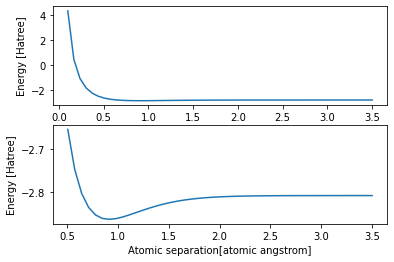

In [24]:
zoom_index = np.where(DM_groundEnergy_list < -2.6)
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(DM_R_list, DM_groundEnergy_list)
ax0.set_xlabel("Atomic separation[atomic angstrom]")
ax0.set_ylabel("Energy [Hatree]")
ax1.plot(DM_R_list[zoom_index], DM_groundEnergy_list[zoom_index])
ax1.set_xlabel("Atomic separation[atomic angstrom]")
ax1.set_ylabel("Energy [Hatree]")
plt.show()  

## Direct result from HF state

In [25]:
helonium_r = np.linspace(0.1, 3.5, 51)
HF_R_list, HF_groundState_list, HF_groundEnergy_list, HF_success_list, HF_energy_min, HF_r_min \
    = get_dissociation_curve(helonium_r, maxiter = 100, gtol = 1e-4, get_expectation_func =  get_expectation_from_Cirq, simulation=True, repetitions=100, optimization=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [05:33<00:00,  6.53s/it]

The minimum energy = -2.8624545539161996, and its corresponding atomic separation = 0.916 Angstroms.


In [26]:
helonium = create_helonium(r= HF_r_min, show_energy=True, user_energy=HF_energy_min)

Calculated energy from different methods:
|===============================================================================================================================================================================|
|          method         |      user_energy       | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8624545539161996   |  -2.8543033962861633   |   -2.862692305871687   |  -2.8608053530099458   |  -2.8626923701359916   |  -2.8626923701359925   |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      relative_error     |      -8.30743e-05      |     -0.00293044

<Figure size 1440x7200 with 0 Axes>

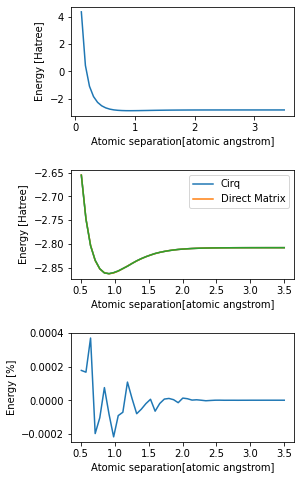

In [27]:
zoom_index = np.where(HF_groundEnergy_list < -2.6)
plt.figure(figsize = (20, 100))
fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
fig.set_figheight(8)
fig.set_figwidth(4)

plt.subplots_adjust(wspace =0, hspace =0.5)
ax0.plot(HF_R_list, HF_groundEnergy_list)
ax0.set_xlabel("Atomic separation[atomic angstrom]")
ax0.set_ylabel("Energy [Hatree]")

ax1.plot(HF_R_list[zoom_index], HF_groundEnergy_list[zoom_index])
DM_zoom_index = np.where(DM_groundEnergy_list < -2.6)
ax1.plot(DM_R_list[DM_zoom_index], DM_groundEnergy_list[DM_zoom_index])
ax1.set_xlabel("Atomic separation[atomic angstrom]")
ax1.set_ylabel("Energy [Hatree]")
ax1.legend(["Cirq", "Direct Matrix"])
ax1.plot(HF_R_list[zoom_index], HF_groundEnergy_list[zoom_index])

ax2.plot(HF_R_list[zoom_index], (HF_groundEnergy_list[zoom_index] - DM_groundEnergy_list[zoom_index])/(DM_groundEnergy_list[zoom_index]))
ax2.set_xlabel("Atomic separation[atomic angstrom]")
ax2.set_ylabel("Energy [%]")
plt.show()  

## From circuit simulation based on Cirq

In [28]:
helonium = create_helonium(0.5)
packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian = get_JW_state_and_unitary(helonium)
get_expectation_from_matrix_operation(packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian, repetitions = 1)

-2.6407145118520687

In [29]:
helonium = create_helonium(0.5)
packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian = get_JW_state_and_unitary_cirq(helonium)
get_expectation_from_Cirq(packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian, repetitions = 100000)
get_required_shots(hamiltonian)

7494684

In [30]:
helonium = create_helonium(0.916)
packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian = get_JW_state_and_unitary_cirq(helonium)
get_expectation_from_Cirq(packed_amplitudes, n_qubits, n_electrons, HF_state, hamiltonian, repetitions = 100000)
get_required_shots(hamiltonian)

10418289

In [31]:
helonium_r = np.linspace(0.1, 3.5, 51)
R_list, groundState_list, groundEnergy_list, success_list, sim_energy_min, sim_r_min \
    = get_dissociation_curve(helonium_r, maxiter = 10000, gtol = 1e-4, get_expectation_func =  get_expectation_from_Cirq, simulation=True, repetitions=10000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [6:58:21<00:00, 492.18s/it]

The minimum energy = -2.8610361329473344, and its corresponding atomic separation = 0.9840000000000001 Angstroms.


In [32]:
success_list

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [33]:
helonium = create_helonium(r= sim_r_min, show_energy=True, user_energy=sim_energy_min)

Calculated energy from different methods:
|===============================================================================================================================================================================|
|          method         |      user_energy       | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8610361329473344   |   -2.853468764027987   |   -2.860977671901131   |  -2.8594248244675993   |  -2.8609776546563035   |   -2.860977654656302   |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      relative_error     |       2.044e-05        |     -0.00262458

<Figure size 1440x7200 with 0 Axes>

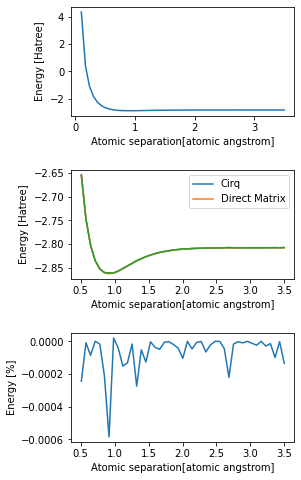

In [34]:
zoom_index = np.where(groundEnergy_list < -2.6)
plt.figure(figsize = (20, 100))
fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
fig.set_figheight(8)
fig.set_figwidth(4)

plt.subplots_adjust(wspace =0, hspace =0.5)
ax0.plot(R_list, groundEnergy_list)
ax0.set_xlabel("Atomic separation[atomic angstrom]")
ax0.set_ylabel("Energy [Hatree]")

ax1.plot(R_list[zoom_index], groundEnergy_list[zoom_index])
DM_zoom_index = np.where(DM_groundEnergy_list < -2.6)
ax1.plot(DM_R_list[DM_zoom_index], DM_groundEnergy_list[DM_zoom_index])
ax1.set_xlabel("Atomic separation[atomic angstrom]")
ax1.set_ylabel("Energy [Hatree]")
ax1.legend(["Cirq", "Direct Matrix"])
ax1.plot(R_list[zoom_index], groundEnergy_list[zoom_index])

ax2.plot(R_list[zoom_index], (groundEnergy_list[zoom_index] - DM_groundEnergy_list[zoom_index])/(DM_groundEnergy_list[zoom_index]))
ax2.set_xlabel("Atomic separation[atomic angstrom]")
ax2.set_ylabel("Energy [%]")
plt.show()  